In [25]:
import tensorflow as tf
import numpy as np
from datetime import datetime
import os
import tensorflow_hub as hub

num_epochs = 100
batch_size = 128
learning_rate = 0.001
data_dir = './data/fer2013/'
train_dir = data_dir + 'train/'
test_dir = data_dir + 'valid/'

checkpoint_path = "training_fer2013_hub_mobilenetv2_1/cp-{epoch:04d}.ckpt"
checkpoint_dir = os.path.dirname(checkpoint_path)
log_dir = "./tensorboard/fer2013_hub_mobilenetv2_" + datetime.now().strftime("%Y%m%d-%H%M%S")

class FixedImageDataGenerator(tf.keras.preprocessing.image.ImageDataGenerator):
    def standardize(self, x):
        if self.featurewise_center:
            x = ((x/255.) - 0.5) * 2.
        return x
    
def train():
    # 0 anger 生气； 1 disgust 厌恶； 2 fear 恐惧； 3 happy 开心； 4 sad 伤心；5 surprised 惊讶； 6 normal 中性
    datagen = FixedImageDataGenerator(
        rescale=1./255,
        #featurewise_center=True,  # 数据集去中心化
        rotation_range=10,        # 旋转角度范围
        width_shift_range=0.1,    # 水平位置平移
        height_shift_range=0.1,   # 上下位置平移
        horizontal_flip=True,   # 随机水平翻转
        #fill_mode='nearest'     # 填充模式
        )
    test_datagen =  FixedImageDataGenerator(rescale=1./255)
    
    train_generator = datagen.flow_from_directory(
        train_dir,  # this is the target directory
        target_size=(96, 96),  # all images will be resized to 48x48
        batch_size=batch_size,
        class_mode='sparse')  # since we use sparse_categorical_crossentropy loss, we need categorical labels
    test_generator = datagen.flow_from_directory(
        test_dir,
        target_size=(96, 96),
        batch_size=batch_size,
        class_mode='sparse')
    
    history = model.fit_generator(
         train_generator,
         steps_per_epoch=28265 / batch_size,
         epochs=num_epochs,
         verbose=1,
         validation_data=test_generator,
         callbacks=[cp_callback_mc, reduce_lr, earlystop_callback]
         )
    return history

def test():
    # 构建测试数据集
    test_datagen =  FixedImageDataGenerator(rescale=1./255)
    test_generator = test_datagen.flow_from_directory(
        test_dir,
        target_size=(96, 96),
        batch_size=batch_size,
        class_mode='sparse')
    
    print(model.evaluate(test_generator))
    
if __name__ ==  '__main__':
    """
    feature_extractor_url = "https://tfhub.dev/google/imagenet/mobilenet_v2_050_96/feature_vector/4"
    feature_extractor_layer = hub.KerasLayer(feature_extractor_url,
                                         input_shape=(96,96,3))
    feature_extractor_layer.trainable = False
    """

    base_model = tf.keras.applications.MobileNetV2(input_shape=(48, 48, 3),
                                               include_top=False,
                                               weights='imagenet')
    base_model.trainable = True
    final_tune_at = 100
    for layer in base_model.layers[:final_tune_at]:
        layer.trainable = False
    base_model.summary()

    
    model = tf.keras.Sequential([
        feature_extractor_layer,
        tf.keras.layers.Dropout(0.2),
        tf.keras.layers.Dense(units=7, activation=tf.nn.softmax)     
    ])
    model.summary()
    model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=learning_rate),
                    loss=tf.keras.losses.sparse_categorical_crossentropy,
                    metrics=[tf.keras.metrics.sparse_categorical_accuracy])
    
    cp_callback_mc = tf.keras.callbacks.ModelCheckpoint(filepath=checkpoint_path,
                                                        save_weights_only=True,
                                                        save_best_only=True,
                                                        monitor='val_loss',
                                                        mode='min',
                                                        verbose=1)
    latest = tf.train.latest_checkpoint(checkpoint_dir)
    if(latest != None):
        model.load_weights(latest).expect_partial()

    #tensorboard_callback = tf.keras.callbacks.TensorBoard(log_dir=log_dir, histogram_freq=1)
    #tensorboard_callback.set_model(model)
    earlystop_callback = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=30, restore_best_weights=True)   #20epoch val_loss没有改善停止运行
    reduce_lr = tf.keras.callbacks.ReduceLROnPlateau(monitor='val_loss',
                                                     patience=5,
                                                     factor=0.2,  #降低因子，每次降低*0.2
                                                     cooldown=5, #冷却时间5epoch
                                                     verbose=1)   # 设置学习率衰减，经过5epoch，loss未衰减学习率*0.1


Model: "mobilenetv2_1.00_224"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_11 (InputLayer)           [(None, 48, 48, 3)]  0                                            
__________________________________________________________________________________________________
Conv1_pad (ZeroPadding2D)       (None, 49, 49, 3)    0           input_11[0][0]                   
__________________________________________________________________________________________________
Conv1 (Conv2D)                  (None, 24, 24, 32)   864         Conv1_pad[0][0]                  
__________________________________________________________________________________________________
bn_Conv1 (BatchNormalization)   (None, 24, 24, 32)   128         Conv1[0][0]                      
_______________________________________________________________________________

In [13]:
len(base_model.layers)

155

In [10]:
    history = train()

Found 28370 images belonging to 7 classes.
Found 2154 images belonging to 7 classes.
Epoch 1/10
220/220 [============================>.] - ETA: 1s - loss: 2.0199 - sparse_categorical_accuracy: 0.2428
Epoch 00001: val_loss improved from inf to 2.42264, saving model to training_fer2013_hub_mobilenetv2/cp-0001.ckpt
221/220 [==============================] - 365s 2s/step - loss: 2.0188 - sparse_categorical_accuracy: 0.2429 - val_loss: 2.4226 - val_sparse_categorical_accuracy: 0.1281
Epoch 2/10
220/220 [============================>.] - ETA: 1s - loss: 1.8150 - sparse_categorical_accuracy: 0.2886
Epoch 00002: val_loss improved from 2.42264 to 2.26553, saving model to training_fer2013_hub_mobilenetv2/cp-0002.ckpt
221/220 [==============================] - 349s 2s/step - loss: 1.8144 - sparse_categorical_accuracy: 0.2888 - val_loss: 2.2655 - val_sparse_categorical_accuracy: 0.1314
Epoch 3/10
220/220 [============================>.] - ETA: 1s - loss: 1.7562 - sparse_categorical_accuracy: 0.305

<Figure size 432x288 with 0 Axes>

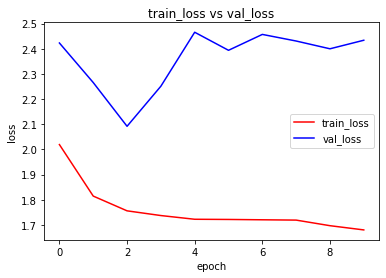

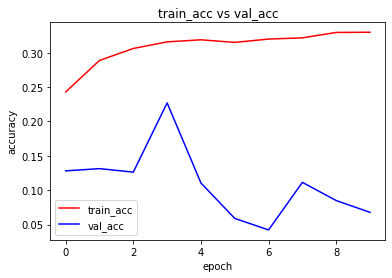

<Figure size 432x288 with 0 Axes>

In [11]:
from matplotlib import pyplot as plt
%matplotlib inline

train_loss=history.history['loss']
val_loss=history.history['val_loss']
train_acc=history.history['sparse_categorical_accuracy']
val_acc=history.history['val_sparse_categorical_accuracy']

epochs = range(len(train_acc))

plt.plot(epochs,train_loss,'r', label='train_loss')
plt.plot(epochs,val_loss,'b', label='val_loss')
plt.title('train_loss vs val_loss')
plt.xlabel('epoch')
plt.ylabel('loss')
plt.legend()
plt.figure()

plt.plot(epochs,train_acc,'r', label='train_acc')
plt.plot(epochs,val_acc,'b', label='val_acc')
plt.title('train_acc vs val_acc')
plt.xlabel('epoch')
plt.ylabel('accuracy')
plt.legend()
plt.figure()